In [1]:
import pandas as pd
import numpy as np
from generate_data import generate_data
import matplotlib.pyplot as plt
from discrete_lognormal import DiscreteLognormal
import statsmodels.api as sm
plt.rcParams["figure.figsize"] = (12,6)
import warnings
from timeit import default_timer as timer

/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
data = generate_data()

In [3]:
data.x_df.head()
# days since start is z normalized

,intercept,days_since_start,days_since_start_squared,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,seasonality_cos,seasonality_sin
0,1.0,-1.729679,2.228932,0,0,0,0,0,1,0.999852,0.017213
1,1.0,-1.726517,2.216707,0,0,0,0,0,0,0.999407,0.034422
2,1.0,-1.723355,2.204505,1,0,0,0,0,0,0.998667,0.051620
3,1.0,-1.720193,2.192325,0,1,0,0,0,0,0.997630,0.068802
4,1.0,-1.717031,2.180168,0,0,1,0,0,0,0.996298,0.085965


In [4]:
gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
gpois_res = gpois_mdl.fit(method="ncg")

Optimization terminated successfully.
         Current function value: 6.035090
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 7


In [5]:
gpois_res.params

intercept                   5.221794
days_since_start            0.336793
days_since_start_squared   -0.140545
day_of_week_1               0.257947
day_of_week_2               0.300532
day_of_week_3               0.317307
day_of_week_4               0.331263
day_of_week_5               0.188896
day_of_week_6               0.047988
seasonality_cos             0.136056
seasonality_sin            -0.084722
alpha                       7.177657
dtype: float64

In [6]:
print(gpois_res.summary2())

                       Results: GeneralizedPoisson
Model:                 GeneralizedPoisson  Pseudo R-squared:  0.050      
Dependent Variable:    y                   AIC:               13240.8479 
Date:                  2022-04-05 10:38    BIC:               13300.8300 
No. Observations:      1095                Log-Likelihood:    -6608.4    
Df Model:              10                  LL-Null:           -6956.7    
Df Residuals:          1084                LLR p-value:       3.4400e-143
Converged:             1.0000              Scale:             1.0000     
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
intercept                 5.2218   0.0394 132.4985 0.0000  5.1446  5.2990
days_since_start          0.3368   0.0150  22.4724 0.0000  0.3074  0.3662
days_since_start_squared -0.1405   0.0139 -10.1255 0.0000 -0.

In [7]:
# Marginal effects
me = gpois_res.get_margeff(method='dydx')
me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
 GeneralizedPoisson Marginal Effects 
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
============================================================================================
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
days_since_start            82.7381      3.906     21.182      0.000      75.082      90.394
days_since_start_squared   -34.5270      3.453     -9.999      0.000     -41.295     -27.759
day_of_week_1               63.3685     12.648      5.010      0.000      38.579      88.158
day_of_week_2               73.8302     12.624      5.848      0.000      49.087      98.574
day_of_week_3               77.9512     12.630      6.172      0.000      53.196     102.706
day_of_week_4               81.3797     12.540      6.489      0.000      56.801     105.959
day_of_week_5               46.4051     12.779      3.631      0.000      21.359      71.452
day_of_week_6               11.7889     13.029      0.905      0.366     -13.747      37.325
seasonality_cos             33.4241      4.686      7.133      0.000      24.240      42.608
seasonality_sin            -20.8133      4.860     -4.282      0.000     -30.340     -11.287
============================================================================================
"""

In [8]:
names = list(data.x_df)
names_alpha = [s + "_alpha" for s in names]

In [9]:
# np.seterr(divide = 'warn')
# np.seterr(invalid= 'warn')

start_params = np.zeros(22)
start_params[:11] = gpois_res.params[:11]
start_params[11] = -1.
mod = DiscreteLognormal(data.y, data.x_df, extra_params_names=names_alpha)

mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=1e-4)
print(mod_res.summary())
print(f"True Beta: {data.beta}")
print(f"True Alpha: {data.alpha}")

Optimization terminated successfully.
         Current function value: 5.961259
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 8
                          DiscreteLognormal Results                           
Dep. Variable:                      y   Log-Likelihood:                -6527.6
Model:              DiscreteLognormal   AIC:                         1.308e+04
Method:            Maximum Likelihood   BIC:                         1.313e+04
Date:                Tue, 05 Apr 2022                                         
Time:                        10:38:50                                         
No. Observations:                1095                                         
Df Residuals:                    1084                                         
Df Model:                          10                                         
                                     coef    std err          z      P>|z|      [0.025  

In [10]:
# Test Newton method
mod_res_newton = mod.fit(method = "newton", start_params = start_params, maxiter=100, penalty=1e-4)

Optimization terminated successfully.
         Current function value: 5.961259
         Iterations 6


In [11]:
# Test first-order EM
mod_em_first = mod.fit(
    start_params=start_params,
    method="EM", 
    use_hessian=False,
    maxiter=1000,
    step_size=1e-3,
    tol=1e-6,
    penalty=1e-4)

Using EM algorithm
Iteration 0 loss: 6.278420119484279
Iteration 1 loss: 6.0076450859298705
Iteration 2 loss: 5.9830152723510075
Iteration 3 loss: 5.975144572661711
Iteration 4 loss: 5.969165473522366
Iteration 5 loss: 5.966934993138356
Iteration 6 loss: 5.965653604466957
Iteration 7 loss: 5.964752104298815
Iteration 8 loss: 5.964282320812055
Iteration 9 loss: 5.964007917865029
Iteration 10 loss: 5.963736062396047
Iteration 11 loss: 5.963553765677589
Iteration 12 loss: 5.963431793901176
Iteration 13 loss: 5.96327923761008
Iteration 14 loss: 5.963142538406591
Iteration 15 loss: 5.963030618085117
Iteration 16 loss: 5.96292922469959
Iteration 17 loss: 5.96284337826645
Iteration 18 loss: 5.962739996002101
Iteration 19 loss: 5.962651959939521
Iteration 20 loss: 5.962568875726257
Iteration 21 loss: 5.962508523779052
Iteration 22 loss: 5.962426652759119
Iteration 23 loss: 5.96235592154091
Iteration 24 loss: 5.962287920590109
Iteration 25 loss: 5.962244708399901
Iteration 26 loss: 5.9621798349

In [12]:
# Test second-order EM
mod_em_second = mod.fit(
    start_params=start_params,
    method="EM",
    use_hessian=True,
    maxiter=100,
    tol=1e-6,
    penalty=1e-4)
# Sensitive to good starting values

Using EM algorithm
Iteration 0 loss: 6.278420119484279
Iteration 1 loss: 5.989705628251108
Iteration 2 loss: 5.962529463254715
Iteration 3 loss: 5.961305298079668
Iteration 4 loss: 5.9612881911174656


In [14]:
def fittedmean(res):
    return pd.Series(res.exog @ res.params[:11])

def fittedvar(res):
    return pd.Series(np.exp(res.exog @ res.params[11:]))

def mse(yhat, y):
    r = y - yhat
    return np.mean(r**2)

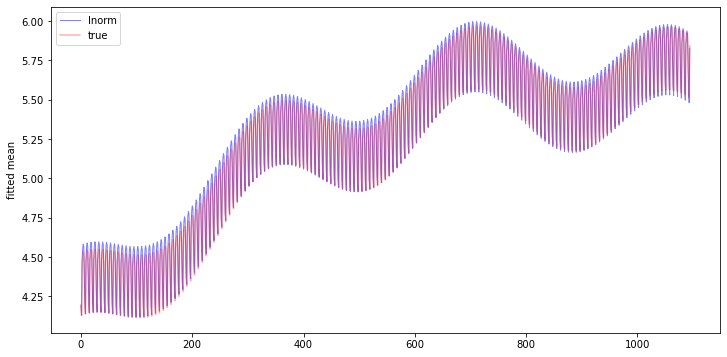

In [15]:
fittedmean(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

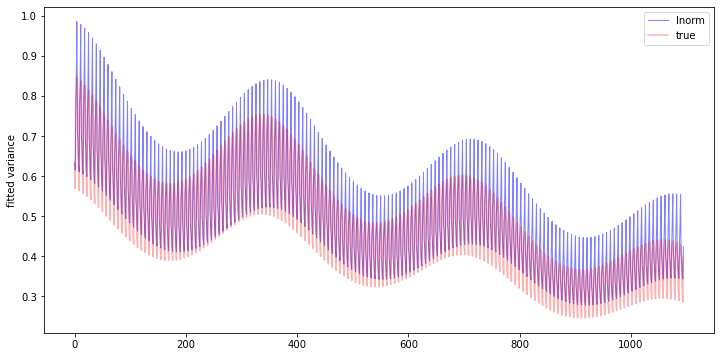

In [16]:
fittedvar(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.sigma, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted variance")
plt.show()

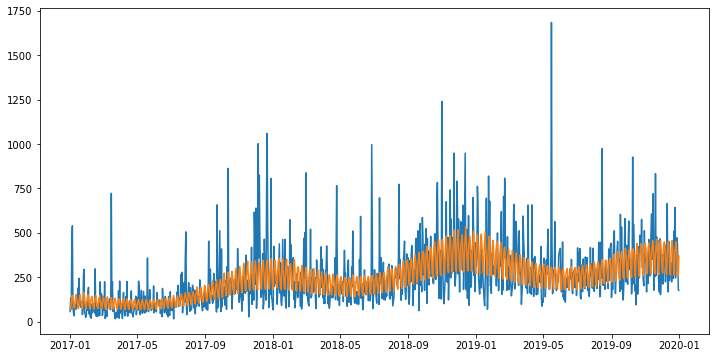

In [17]:
Y_hat = mod_res.predict(n=1000)
plt.plot(data.days, data.y)
plt.plot(data.days, Y_hat)
plt.show()

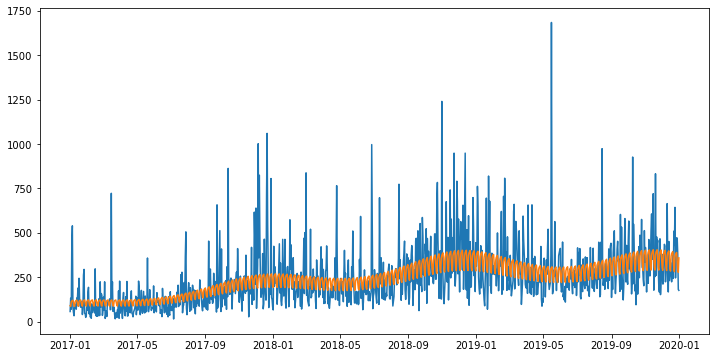

In [18]:
plt.plot(data.days, data.y)
plt.plot(data.days, gpois_res.predict())
plt.show()

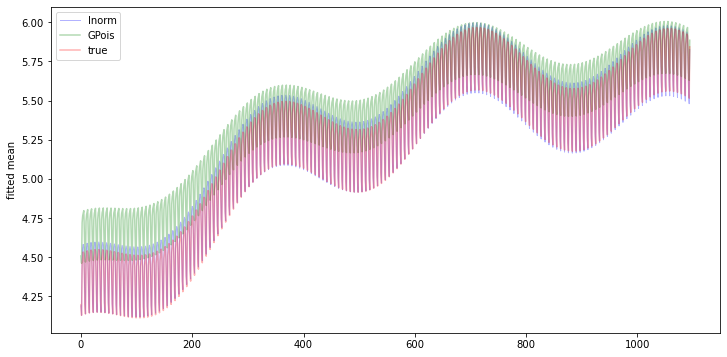

In [19]:
fittedmean(mod_res).plot(alpha = 0.3, color = "blue", linewidth = 1, label = "lnorm")
gpois_res.fittedvalues.plot(alpha = 0.3, color = "green", label = "GPois")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

In [20]:
# Negative Hessian is PD at optimal values
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, -1., -0.2, -0.03, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.16, -0.05])
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
np.linalg.eigvals(-mod.hessian(starting_vals))

array([1238.54373539, 1164.52918858, 1111.37930827,  994.89484537,
        609.42777473,  537.97547064,  486.24810313,  386.79185228,
        264.26316738,   19.69876191,    7.27399243,  236.72773777,
         60.41891546,   89.5215312 ,   68.70408689,   71.61934331,
        113.55427366,  160.1307842 ,  153.67776145,  154.97601966,
        157.38997531,  156.63623872])

In [21]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     bs = mod_res.bootstrap(nrep=1, method="ncg", store = 0, disp = 0) # we can bootstrap SE

In [22]:
# bs[0] #mean estimates

## Simulation 

In [26]:
# What else should we test?
N = 50
penalty = 1e-4
sim_params = list()
sim_mse = list()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        sim_params.append(["pois"] + pois_res.params[:11].tolist())
        
        gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
        gpois_res = gpois_mdl.fit(disp=0)
        sim_params.append(["gpois"]+ gpois_res.params[:11].tolist())
        
        NB1_mdl = sm.NegativeBinomialP(data.y, data.x_df,p=1)
        NB1_res = NB1_mdl.fit(disp=0)
        sim_params.append(["NB1"]+ NB1_res.params[:11].tolist())
        
        mod = DiscreteLognormal(data.y, data.x_df, extra_params_names=names_alpha)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        sim_params.append(["lnorm"] + mod_res.params[:11].tolist()) # Just the model coeffecients

        data = generate_data() #new data
        Xnew = data.x_df
        # out of sample prediction MSE
        sim_mse.append([mse(mod_res.predict(exog=Xnew), data.y), mse(pois_res.predict(exog=Xnew), data.y), 
                        mse(gpois_res.predict(exog=Xnew), data.y), mse(NB1_res.predict(exog=Xnew), data.y)])


In [27]:
sim_params = pd.DataFrame(sim_params, columns=["model"] + data.x_df.columns.to_list())

In [28]:
sim_params.groupby(by = "model").mean().T

model,NB1,gpois,lnorm,pois
intercept,5.173796,5.218058,4.997323,5.074128
days_since_start,0.345454,0.353880,0.400318,0.348081
days_since_start_squared,-0.139919,-0.131173,-0.168023,-0.166338
day_of_week_1,0.295159,0.245433,0.333382,0.396220
day_of_week_2,0.312077,0.256447,0.355716,0.422168
day_of_week_3,0.357420,0.291475,0.405307,0.488233
day_of_week_4,0.343829,0.280544,0.391855,0.471312
day_of_week_5,0.225961,0.188512,0.255191,0.303994
day_of_week_6,0.063106,0.053039,0.072006,0.085272
seasonality_cos,0.177708,0.147659,0.199157,0.235296


In [29]:
#MSE
pd.DataFrame(sim_mse, columns=["lnorm", "pois", "gpois", "NB1"]).describe()

,lnorm,pois,gpois,NB1
count,50.000000,50.000000,50.000000,50.000000
mean,20239.773899,20250.317808,20845.140455,20491.429658
std,3468.758019,3511.795857,3720.206842,3652.045168
min,15108.374491,15103.537721,15662.121129,15266.176207
25%,18365.799544,18309.620960,18801.235611,18506.916484
50%,19469.883965,19473.652312,20021.893088,19660.515438
75%,21148.335291,21167.775302,22154.789086,21652.021836
max,36449.222774,36673.569756,38163.708122,37504.976041


In [30]:
N = 50
sim_solver_times = list()
sim_solver_fcalls = list()
penalty = 1e-4

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        fcalls = []
        
        # Seed with poisson parameters
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        
        mod = DiscreteLognormal(data.y, data.x_df, extra_params_names=names_alpha)
        
        start = timer()
        mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        ncg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "cg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        cg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        bfgs = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "powell", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        powell = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        sim_solver_times.append([ncg, cg, bfgs, powell])
        sim_solver_fcalls.append(fcalls)

In [31]:
pd.DataFrame(sim_solver_times, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,50.000000,50.000000,50.000000,50.000000
mean,0.211422,0.403229,0.091167,0.433631
std,0.025799,0.042966,0.002293,0.024492
min,0.183449,0.307375,0.084906,0.345640
25%,0.201025,0.371876,0.089642,0.426859
50%,0.206783,0.401936,0.091255,0.430529
75%,0.211297,0.443161,0.092734,0.434060
max,0.311162,0.466511,0.096142,0.518807


In [32]:
pd.DataFrame(sim_solver_fcalls, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,50.000000,50.000000,50.000000,50.000000
mean,18.240000,136.220000,26.760000,1158.880000
std,9.505229,15.206457,0.686904,65.347623
min,13.000000,102.000000,25.000000,916.000000
25%,15.000000,126.000000,26.000000,1146.250000
50%,16.000000,135.500000,27.000000,1150.500000
75%,17.000000,149.500000,27.000000,1153.750000
max,57.000000,160.000000,28.000000,1384.000000
